In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADCLOUD_MODEL_STATE_DICT_PATH=os.getenv("RADCLOUD_MODEL_STATE_DICT_PATH")
MODEL_TRAINING_DATASET_PATH=os.getenv("MODEL_TRAINING_DATASET_PATH")
GENERATED_DATASETS_PATH=os.getenv("GENERATED_DATASETS_PATH")


sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_radar_processing.processors.synthetic_array_beamformer_processor_revA import SyntheticArrayBeamformerProcessor

from mmwave_model_integrator.input_encoders.radsar_encoder import RadSAREncoder
from mmwave_model_integrator.ground_truth_encoders.radsar_gt_encoder import RadSarGTEncoder
from mmwave_model_integrator.plotting.plotter_radsar import PlotterRadSar
from mmwave_model_integrator.dataset_generators.radsar_dataset_generator import RadSARDatasetGenerator

/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#setup the config manager
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#determine the paths to all of the datasets
#determine the paths to all of the datasets
train_datasets = ["NORTH_RadSAR_Test_1","CPSL_ENDFIRE_SAR_TEST_1"]
train_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,"RadSAR",dataset) for dataset in train_datasets]

test_datasets = ["WILK_ENDFIRE_SAR_TEST_1"]
test_scenario_folders = [os.path.join(MODEL_TRAINING_DATASET_PATH,"RadSAR",dataset) for dataset in test_datasets]

In [4]:
#initializing the dataset generator
dataset_path = train_scenario_folders[0]
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0_adc",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full",
    vehicle_odom_folder="vehicle_odom"
)

found 304 radar samples
found 304 lidar samples
found 304 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 304 vehicle velocity samples
found 304 vehicle odometry samples


In [5]:
#initialize the encoder and decoder
input_encoder = RadSAREncoder(
    config_manager=cfg_manager,
    az_angle_bins_rad=\
        np.deg2rad(np.linspace(
            start=-90,stop=90,num=90
            )),
    min_vel=0.2,
    max_vel_change=0.1,
    mode = SyntheticArrayBeamformerProcessor.ENDFIRE_MODE,
    min_power_threshold_dB=40
)


ground_truth_encoder = RadSarGTEncoder(
    max_range_m=cfg_manager.range_max_m,
    num_range_bins=cfg_manager.get_num_adc_samples(),
    angle_range_rad=[np.deg2rad(-90),np.deg2rad(90)],
    num_angle_bins=90,
    num_previous_frames=0
)

plotter = PlotterRadSar()

alpha: 6.968355977686613 (mag), 16.86260656902793 dB


In [6]:
#go until the encoder is ready
idx = 0
while not input_encoder.full_encoding_ready:

    try: #try accessing the full odometry data
        vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
    except AssertionError: #if not just get the x velocity (forward)
        vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
        vel_data = np.array([vel,0,0])
    
    adc_cube = dataset.get_radar_data(idx)
    
    resp = input_encoder.encode(
        adc_data_cube=adc_cube,
        vels=vel_data
    )
    idx += 1

print(idx)

96


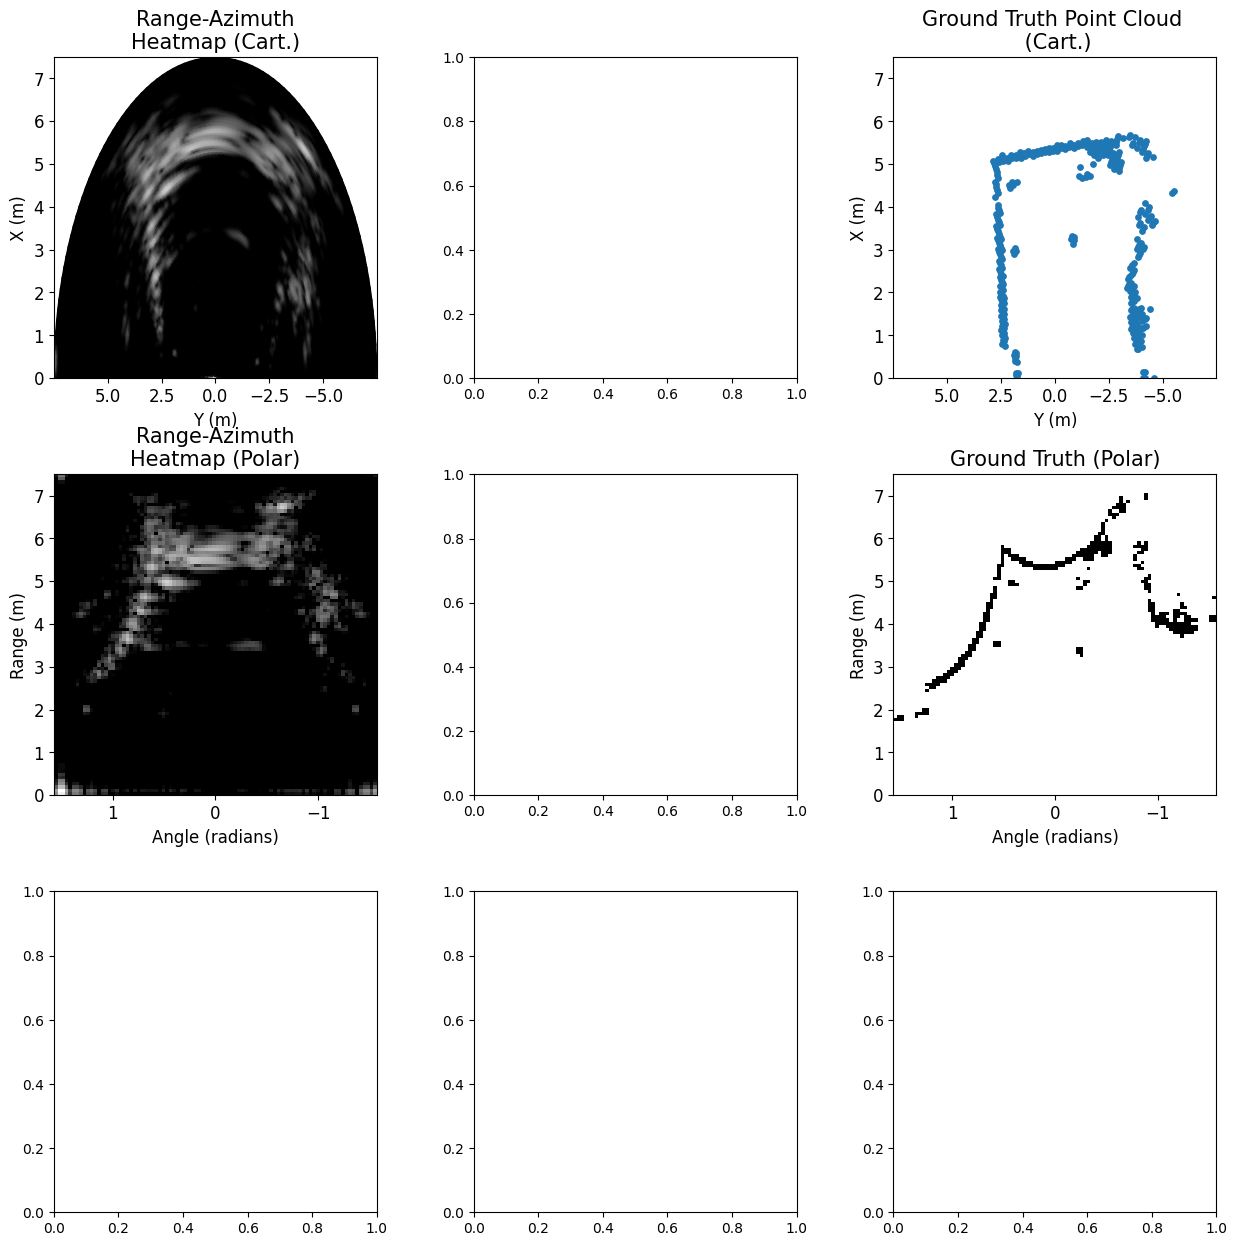

In [7]:
#plot a sample of the input/output for training
adc_cube = dataset.get_radar_data(idx)

try: #try accessing the full odometry data
    vel_data = np.mean(dataset.get_vehicle_odom_data(idx)[:,8:11],axis=0)
except AssertionError: #if not just get the x velocity (forward)
    vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])
    vel_data = np.array([vel,0,0])

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx)

plotter.plot_compilation(
    input_adc_cube=adc_cube,
    input_vels=vel_data,
    input_encoder=input_encoder,
    gt_data=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [8]:
#initialize the dataset generator
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadSAR_train")
dataset_generator = RadSARDatasetGenerator(
    generated_dataset_path=generated_dataset_path,
    dataset_handler=dataset,
    input_encoder=input_encoder,
    ground_truth_encoder=ground_truth_encoder,
    generated_file_name="frame",
    input_encoding_folder="x_s",
    ground_truth_encoding_folder="y_s",
    clear_existing_data=True
)

DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_train
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_train
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_train/x_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_train/x_s
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_train/y_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_train/y_s


In [9]:
#generate the training dataset
dataset_generator.generate_dataset_from_multiple_scenarios(train_scenario_folders)

Generating data from scenario 0 of 2
found 304 radar samples
found 304 lidar samples
found 304 camera samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 304 vehicle velocity samples
found 304 vehicle odometry samples


100%|██████████| 208/208 [00:02<00:00, 75.99it/s] 


generated dataset now has 114 samples
Generating data from scenario 1 of 2
found 296 radar samples
found 296 lidar samples
did not find camera samples
found 296 imu (orientation only) samples
did not find imu (full data) samples
found 296 vehicle velocity samples
found 296 vehicle odometry samples


100%|██████████| 280/280 [00:04<00:00, 57.72it/s] 

generated dataset now has 332 samples


In [10]:
#generating the testing dataset
generated_dataset_path = os.path.join(GENERATED_DATASETS_PATH,"RadSAR_test")
dataset_generator.reset(generated_dataset_path)
dataset_generator.generate_dataset_from_multiple_scenarios(test_scenario_folders)


DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_test
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_test
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_test/x_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_test/x_s
DatasetGenerator._check_for_directory: found directory /home/david/Downloads/generated_datasets/RadSAR_test/y_s
DatasetGenerator._check_for_directory: clearing contents of /home/david/Downloads/generated_datasets/RadSAR_test/y_s
Generating data from scenario 0 of 1
found 613 radar samples
found 613 lidar samples
did not find camera samples
found 613 imu (orientation only) samples
did not find imu (full data) samples
found 613 vehicle velocity samples
found 613 vehicle odometry samples


100%|██████████| 270/270 [00:05<00:00, 47.89it/s]

generated dataset now has 257 samples


In [11]:
from mmwave_model_integrator.config import Config
config_path = "../configs/radsar_single_chirp.py"
config = Config(config_path)

config.print_config()

model=dict(
    type=RadCloudUnet,
    encoder_input_channels=1,
    encoder_out_channels=(64, 128, 256),
    decoder_input_channels=(512, 256, 128),
    decoder_out_channels=64,
    output_channels=1,
    retain_dimmension=False,
    input_dimmensions=(96, 88),
),
generated_dataset=dict(
    input_encoding_folder=x_s,
    ground_truth_encoding_folder=y_s,
    generated_dataset_path=/home/david/Downloads/generated_datasets/RadSAR_train,
),
trainer=dict(
    type=_BaseTorchTrainer,
    model=dict(
        type=RadCloudUnet,
        encoder_input_channels=1,
        encoder_out_channels=(64, 128, 256),
        decoder_input_channels=(512, 256, 128),
        decoder_out_channels=64,
        output_channels=1,
        retain_dimmension=False,
        input_dimmensions=(96, 88),
    ),
    optimizer=dict(
        type=Adam,
        lr=0.001,
    ),
    dataset=dict(
        type=_BaseTorchDataset,
        input_transforms=[{'type': 'RandomRadarNoise', 'noise_level': 0.25}, {'type': 'ToTenso

In [12]:
import mmwave_model_integrator.torch_training.trainers as trainers

trainer_config = config.trainer
trainer_class = getattr(trainers,trainer_config.pop('type'))
trainer = trainer_class(**trainer_config)


ModelTrainer: 282 train, 50 val samples loaded
_BaseTorchTrainer._check_for_directory: found directory working_dir


In [13]:
#train the model
trainer.train_model()

ModelTrainer.train: training the network...


 10%|█         | 1/10 [00:03<00:28,  3.19s/it]

EPOCH: 1/10
	 Train loss: 0.5828340649604797, Val loss:1.1923909187316895


 20%|██        | 2/10 [00:06<00:24,  3.09s/it]

EPOCH: 2/10
	 Train loss: 0.45679038763046265, Val loss:0.9203873872756958


 30%|███       | 3/10 [00:09<00:21,  3.06s/it]

EPOCH: 3/10
	 Train loss: 0.4061960279941559, Val loss:0.8211773633956909


 40%|████      | 4/10 [00:12<00:18,  3.05s/it]

EPOCH: 4/10
	 Train loss: 0.37311455607414246, Val loss:0.7955703735351562


 50%|█████     | 5/10 [00:15<00:15,  3.05s/it]

EPOCH: 5/10
	 Train loss: 0.35052919387817383, Val loss:0.7627171277999878


 60%|██████    | 6/10 [00:18<00:12,  3.04s/it]

EPOCH: 6/10
	 Train loss: 0.3350044786930084, Val loss:0.6878348588943481


 70%|███████   | 7/10 [00:21<00:09,  3.04s/it]

EPOCH: 7/10
	 Train loss: 0.32398971915245056, Val loss:0.608504056930542


 80%|████████  | 8/10 [00:24<00:06,  3.04s/it]

EPOCH: 8/10
	 Train loss: 0.31632453203201294, Val loss:0.567538857460022


 90%|█████████ | 9/10 [00:27<00:03,  3.04s/it]

EPOCH: 9/10
	 Train loss: 0.3110412359237671, Val loss:0.5529265403747559


100%|██████████| 10/10 [00:30<00:00,  3.05s/it]

EPOCH: 10/10
	 Train loss: 0.30690717697143555, Val loss:0.5462146401405334
ModelTrainer.train: total training time 30.52
